# Project ML for portfolio management

The aim of this project is to explore gender differences in central bank communication / speeches using sentiment analysis, inspired by the paper "Leadership, Gender, and Discourse in Monetary Policy: Analyzing Speech Dynamics in the FOMC" (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=5002334).

We will explore gender communication styles in speeches delivered by central bank officials, focusing on whether there are observable differences between male and female central bank leaders.
More specifically, using sentiment analysis and NLP techniques, we will analyze whether male and female speakers differ in the topics they address (topic modeling) and the tone of their speeches (sentiment analysis).


The speeches would be scraped or downloaded from the BIS website, along with the speaker information. I would need to further define which speeches to use / focus on (based on major policy announcements for instance ?).

instructions : 1 : Sharp summary of our results. Should be clear if it works or not.
2 : dataset, can be short if reusing. Or longer if webscrapping  summary statistics, code, …
3 : why is it an important question, why does it matter ? (central bank data). What is your contribution, what do you bring ? what has been done and what changes with what I’m doing. What is new in what you’re doing.
Is the evaluation a backtest or something else, …
4 : results : explain what we’re doing and 
Summary of our test / empirical result. Can be positive or negative. 
5 : did it work or not, what can be improved / added ?
We can also / should !! read a paper and replicate it : google scholar 


1. Introduction
1. Dataset overview
1. Analytics and learning strategies
1. Empirical resuts: baseline and robustness 
1. Conclusion

if you need to add any package, no problem: add cells in your notebook with "pip install my_additional_package" so that I'm aware of what additional packages I need to run your notebook. 
if you use data that you scrapped online, just provide the code to programmatically scrape the data. More generally, I don't want to receive data.csv files. 
if you use .py files to tidy your project, just use a %%writefile magic in the notebook -- so that on my side, I can create the same .py files on the fly. I don't want to receive additional .py files.

In [ ]:
# pip install selenium
# pip install pyLDAvis
# pip install pyLDAvis
# pip install fitz
# pip install frontend

# pip install pdf_plumber
# pip install seaborn
# pip install plotly
# pip install wordcloud
# pip install nltk
# pip install tf-keras
# pip install gensim
# pip install numpy==1.24.6
# pip install spacy

### INTRODUCTION


The opening segment encompasses four essential elements:

- 1 Contextual Background: What is the larger setting of the study? What makes this area of inquiry compelling? What are the existing gaps or limitations within the current body of research? What are some unanswered yet noteworthy questions?

- 2 Project Contributions: What are the specific advancements made by this study, such as in data acquisition, algorithmic development, parameter adjustments, etc.?

- 3 Summary of the main empirical results: What is the main statistical statement? is it significant (e.g. statistically or economically)? 

- 4 Literature and Resource Citations: What are related academic papers? What are the github repositories, expert blogs, or software packages that used in this project? 

references : 
- Leadership, Gender, and Discourse in Monetary Policy: Analyzing Speech Dynamics in the FOMC (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=5002334)
- Information in Central Bank Sentiment: An Analysis of Fed and ECB Communication (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4797935)

### DATASET OVERVIEW

In the dataset profile, one should consider:

- The origin and composition of data utilized in the study. If the dataset is original, then provide the source code to ensure reproducibility.
The dataset is composed of all central bankers' speeches avilable on the BIS website, coming from central banks institutions. The speeches date from 2009 up until 2024 (dates exactes?).
The data was requested through the BIS API and the speeches themselves were scraped from the BIS html pages.
/!\ the data collecting function takes a while to run as there are about 20000 speeches on the BIS website that are then filtered and then scrape corresponding speeches.
The get_central_bank_speeches_urls function requests all speeches individual urls and the load_central_banks_speeches requests all speeches metadata information and then scrapes the speeches content from the html pages if the filter of the institution correponds.


Assign gender to speakers thanks to genderize.io API.

- The chronological accuracy of the data points, verifying that the dates reflect the actual availability of information.
Do a plot with nr of data points per year

- A detailed analysis of descriptive statistics, with an emphasis on discussing the importance of the chosen graphs or metrics.
Plot men vs women speakers

Central Bank Speeches: You need a corpus of speeches delivered by central bank officials, ideally annotated with speaker information (name, gender, role, country, etc.).
Metadata: To analyze gender differences, the dataset must include:
Gender of the speaker.
Date of the speech.
Context (policy announcements, conferences, etc.).

scope (e.g., BIS speeches from 2000 onwards)

In [ ]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import os
from pathlib import Path
import logging
import numpy as np 

import ast
import pprint
from collections import Counter
import re

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
# warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

import pdfplumber  # For parsing PDF files
from io import BytesIO

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [87]:
# build functions
def get_central_bank_speeches_urls():
    '''
    '''
    url = "https://www.bis.org/api/document_lists/cbspeeches.json"
    reviews=[]
    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        speeches = response.json()
        # Get the list of speeches ids ,
        for review in speeches['list']:
            reviews.append(review)
    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")
    
    return(reviews)

review_urls = get_central_bank_speeches_urls()
print(f'There are a total of {len(review_urls)} central bank speeches available.')

There are a total of 20130 central bank speeches available.


In [ ]:
logger = logging.getLogger(__name__)

def clean_directory_path(cache_dir, default_dir="data"):
    if cache_dir is None:
        cache_dir = Path(os.getcwd()) / default_dir
    if isinstance(cache_dir, str):
        cache_dir = Path(cache_dir)
    if not cache_dir.is_dir():
        os.makedirs(cache_dir)
    return cache_dir

In [5]:
# speeches = load_central_banks_speeches(force_reload=False)
# switch 20091

In [89]:
# with PDFs
def load_central_banks_speeches_pdf(cache_dir="data", force_reload=False, progress_bar=False, institutions_filter=[6]):
    """
    """
    filename = clean_directory_path(cache_dir) / "central_banks_speeches_pdf.parquet"
    # load from cache if it exists and not force_reload
    if (filename.exists()) and not force_reload:
        logger.info(f"loading from cache file: {filename}")
        speeches = pd.read_parquet(filename)
    else:
        logger.info("loading from external source")

        # get all speeches URLs
        urls = get_central_bank_speeches_urls()
        if progress_bar:
            review_urls_ = tqdm(urls)
        else:
            review_urls_ = urls


        # get speeches metadata + extract / scrape speech from html page
        all_speeches = []
        base_url_api = "https://www.bis.org/api/documents"
        base_url = "https://www.bis.org"

        # iterate over speeches URLs
        counter=0
        switch=None
        for link in review_urls_ : #tqdm(reviews):
            counter+=1
            speech_data = {}
            review_url = f'{base_url_api}{link}.json'
            # speech_url = f'{base_url}{link}.htm'
            speech_pdf = f'{base_url}{link}.pdf'
            print(f"Processing speech: {review_url}")

            try:
                # Fetch speech page
                review_response = requests.get(review_url)
                review_metadata = review_response.json()
                speech_data.update(review_metadata)

                # Check if 'institutions' exists, skip processing if not
                    # only scrape speech if it's the right institution (filtering before scraping)  
                if 'institutions' in speech_data and any(inst in speech_data['institutions'] for inst in institutions_filter) : #speech_data['institutions'] == institutions_filter :
                    switch = counter
                    try:

                        pdf_response = requests.get(speech_pdf) 
                        # Extract text from the PDF
                        with pdfplumber.open(BytesIO(pdf_response.content)) as pdf:
                            pdf_text = ''.join(page.extract_text() for page in pdf.pages)
                            speech_data['speech_content'] = pdf_text
                    
                        # append speech dict (content + metadata) to all_speeches
                        all_speeches.append(speech_data)

                    except Exception as e:
                        print(f"Failed to process speech: {speech_pdf}, error: {e}")
                        continue 

                else:
                    print(f"Skipping speech {review_url}: Institution not in filter or wrong institution")

            except Exception as e:
                    print(f"Failed to fetch data of review {review_url}, status code: {review_response.status_code}")
                    continue 
        
        # Convert to DataFrame
        speeches = pd.DataFrame(all_speeches)
        
        # Save to cache
        logger.info(f"saving cache file {filename}")
        speeches.to_parquet(filename)
    return speeches

In [99]:
speeches = load_central_banks_speeches_pdf(force_reload=False, progress_bar=True) # 154m32 = 2.5h
speeches.head(5)

,id,path,menu_id,short_title,long_title,publication_start_date,language,pdf_file_size,pdf_pages,has_content,format,sources,authors,recurse_category,institutions,speech_content,topics,abstract
0,6657,/review/r090217b.pdf,256,Jean-Claude Trichet: Ten years of the euro - s...,"Speech by Mr Jean-Claude Trichet, President of...",2009-02-17T11:05:00.000+01:00,en,53,8,False,HTML_abstract,[Central bank],"[{'author_type': 1, 'id': 241, 'name': 'Jean-C...",[Speeches],[6],Jean-Claude Trichet: Ten years of the euro – s...,None,None
1,6660,/review/r090217e.pdf,256,Lucas Papademos: Tackling the financial crisis...,"Speech by Mr Lucas Papademos, Vice President o...",2009-02-17T11:05:00.000+01:00,en,55,8,False,HTML_abstract,[Central bank],"[{'author_type': 1, 'id': 253, 'name': 'Lucas ...",[Speeches],[6],Lucas Papademos: Tackling the financial crisis...,None,None
2,6661,/review/r090218a.pdf,256,"Jean-Claude Trichet: Macroeconomic policies, i...","Address by Mr Jean-Claude Trichet, President o...",2009-02-18T11:05:00.000+01:00,en,29,3,False,HTML_abstract,[Central bank],"[{'author_type': 1, 'id': 241, 'name': 'Jean-C...",[Speeches],[6],"Jean-Claude Trichet: Macroeconomic policies, i...",None,None
3,6665,/review/r090218e.pdf,256,Lorenzo Bini Smaghi: Regulation and supervisor...,"Speech by Mr Lorenzo Bini Smaghi, Member of th...",2009-02-18T11:05:00.000+01:00,en,37,6,False,HTML_abstract,[Central bank],"[{'author_type': 1, 'id': 254, 'name': 'Lorenz...",[Speeches],[6],Lorenzo Bini Smaghi: Regulation and supervisor...,None,None
4,6666,/review/r090219a.pdf,256,Jean-Claude Trichet: Interview with China Finance,"Interview by Mr Jean-Claude Trichet, President...",2009-02-19T11:05:00.000+01:00,en,20,3,False,HTML_abstract,[Central bank],"[{'author_type': 1, 'id': 241, 'name': 'Jean-C...",[Speeches],[6],Jean-Claude Trichet: Interview with China Fina...,None,None


delete unproperly downloaded PDF content (contains 'cid')

In [105]:
# Function to find all '(cid:XX)' patterns in text
def find_cid_patterns(text):
    # Regex to match '(cid:XX)' where XX are digits
    pattern = r'\(cid:\d+\)'
    return re.findall(pattern, text)

# Apply the function to find all 'cid' patterns in each speech
speeches['cid_patterns'] = speeches['speech_content'].apply(find_cid_patterns)
# Filter speeches containing 'cid' patterns
cid_speeches = speeches[speeches['cid_patterns'].str.len() > 0]
speeches = speeches[speeches['cid_patterns'].str.len() <= 0]
print(f'There are {len(cid_speeches)} speeches to delete')

There are 99 speeches to delete


In [108]:
# Check for empty or null strings, where we weren't able to retrieve the PDF content automatically
len(speeches[speeches['speech_content'].str.strip() == ""])
empty_speeches = speeches[speeches['speech_content'].str.strip() == ""]
print(f"Number of empty speeches: {len(empty_speeches)}")
speeches = speeches[speeches['speech_content'].str.strip() != ""]

Number of empty speeches: 6


In [110]:
print(f"There are {len(speeches)} speeches in total.")
speeches.columns

There are 1859 speeches in total.


Index(['id', 'path', 'menu_id', 'short_title', 'long_title',
       'publication_start_date', 'language', 'pdf_file_size', 'pdf_pages',
       'has_content', 'format', 'sources', 'authors', 'recurse_category',
       'institutions', 'speech_content', 'topics', 'abstract', 'cid_patterns'],
      dtype='object')

Extract speaker names + map their gender 

In [111]:
def process_authors(authors_array):
    if isinstance(authors_array, np.ndarray):
        authors_list = authors_array.tolist()
        for author in authors_list:
            if 'name' in author and author['name'] == 'Benoît C&#339;uré': # Replace all occurrences of 'Benoît C&#339;uré' with 'Coeuré'
                author['name'] = 'Benoît Coeuré'
        return authors_list
    return authors_array

In [112]:
speeches['authors'] = speeches['authors'].apply(process_authors)
speeches['speaker_name'] = speeches['authors'].apply(lambda authors: authors[0]['name'] if authors else None) # Extract primary speaker name

# Get the count of each name
name_counts = Counter(speeches['speaker_name'])

# get unique names :
all_names = set(speeches['speaker_name'])
print("All Author Names:", all_names)
print("Name Counts:")
pprint.pp(name_counts)

All Author Names: {'Elizabeth McCaul', 'Gertrude Tumpel-Gugerell', 'Peter Praet', 'Andrew G Haldane', 'Linah K Mohohlo', 'Lucas Papademos', 'Fabio Panetta', 'Claudia Buch', 'Mario Draghi', 'Jean-Claude Trichet', 'Jürgen Stark', 'Lorenzo Bini Smaghi', 'Isabel Schnabel', 'Vítor Constâncio', 'Benoît Coeuré', 'Christine Lagarde', 'Sarah Bloom Raskin', 'Yves Mersch', 'Piero Cipollone', 'Frank Elderson', 'Jörg Asmussen', 'Philip R Lane', 'Joseph Yam', 'Sabine Lautenschläger', 'José Manuel González-Páramo', 'Luis de Guindos'}
Name Counts:
Counter({'Mario Draghi': 277,
         'Benoît Coeuré': 253,
         'Jean-Claude Trichet': 177,
         'Yves Mersch': 157,
         'Peter Praet': 144,
         'Christine Lagarde': 136,
         'Vítor Constâncio': 121,
         'Luis de Guindos': 98,
         'Sabine Lautenschläger': 94,
         'Lorenzo Bini Smaghi': 56,
         'Fabio Panetta': 51,
         'Philip R Lane': 48,
         'Isabel Schnabel': 45,
         'Jörg Asmussen': 40,
         

C:\Users\marie\AppData\Local\Temp\ipykernel_39564\3283010347.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\marie\AppData\Local\Temp\ipykernel_39564\3283010347.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [113]:
# with genderize.io API 

def fetch_gender(name) :
    """
    Use Genderize.io to fetch gender for a given name.
    """
    url = f"https://api.genderize.io"
    params = {"name": name}
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()  # Raise an error for bad HTTP responses
        gender_data = response.json()
        return gender_data.get("gender"), gender_data.get("probability")
    except requests.exceptions.RequestException as e:
        print(f"Error fetching gender for {name}: {e}")
        return None, None

fetched_genders = {}
for name in all_names :
    fetched_genders[name] = fetch_gender(name)

pprint.pp(fetched_genders)

speeches[['gender', 'confidence']] = speeches['speaker_name'].map(fetched_genders).apply(pd.Series)
speeches.head(3)

{'Elizabeth McCaul': ('female', 1.0),
 'Gertrude Tumpel-Gugerell': ('female', 0.98),
 'Peter Praet': ('male', 1.0),
 'Andrew G Haldane': ('male', 1.0),
 'Linah K Mohohlo': ('female', 0.98),
 'Lucas Papademos': ('male', 0.99),
 'Fabio Panetta': ('male', 1.0),
 'Claudia Buch': ('female', 0.99),
 'Mario Draghi': ('male', 0.99),
 'Jean-Claude Trichet': ('male', 1.0),
 'Jürgen Stark': ('male', 1.0),
 'Lorenzo Bini Smaghi': ('male', 1.0),
 'Isabel Schnabel': ('female', 0.99),
 'Vítor Constâncio': ('male', 1.0),
 'Benoît Coeuré': ('male', 1.0),
 'Christine Lagarde': ('female', 1.0),
 'Sarah Bloom Raskin': ('female', 0.99),
 'Yves Mersch': ('male', 0.98),
 'Piero Cipollone': ('male', 0.99),
 'Frank Elderson': ('male', 1.0),
 'Jörg Asmussen': ('male', 1.0),
 'Philip R Lane': ('male', 1.0),
 'Joseph Yam': ('male', 0.99),
 'Sabine Lautenschläger': ('female', 0.99),
 'José Manuel González-Páramo': ('male', 0.98),
 'Luis de Guindos': ('male', 1.0)}


C:\Users\marie\AppData\Local\Temp\ipykernel_39564\2657631053.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\marie\AppData\Local\Temp\ipykernel_39564\2657631053.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,id,path,menu_id,short_title,long_title,publication_start_date,language,pdf_file_size,pdf_pages,has_content,...,authors,recurse_category,institutions,speech_content,topics,abstract,cid_patterns,speaker_name,gender,confidence
0,6657,/review/r090217b.pdf,256,Jean-Claude Trichet: Ten years of the euro - s...,"Speech by Mr Jean-Claude Trichet, President of...",2009-02-17T11:05:00.000+01:00,en,53,8,False,...,"[{'author_type': 1, 'id': 241, 'name': 'Jean-C...",[Speeches],[6],Jean-Claude Trichet: Ten years of the euro – s...,None,None,[],Jean-Claude Trichet,male,1.00
1,6660,/review/r090217e.pdf,256,Lucas Papademos: Tackling the financial crisis...,"Speech by Mr Lucas Papademos, Vice President o...",2009-02-17T11:05:00.000+01:00,en,55,8,False,...,"[{'author_type': 1, 'id': 253, 'name': 'Lucas ...",[Speeches],[6],Lucas Papademos: Tackling the financial crisis...,None,None,[],Lucas Papademos,male,0.99
2,6661,/review/r090218a.pdf,256,"Jean-Claude Trichet: Macroeconomic policies, i...","Address by Mr Jean-Claude Trichet, President o...",2009-02-18T11:05:00.000+01:00,en,29,3,False,...,"[{'author_type': 1, 'id': 241, 'name': 'Jean-C...",[Speeches],[6],"Jean-Claude Trichet: Macroeconomic policies, i...",None,None,[],Jean-Claude Trichet,male,1.00


In [12]:
# in case genderize API doesn't work 
#  manually create a mapping of all speakers genders, with more time and or a largest list of speakers, we could use the genderize.io API
# (checked on wikipedia or BCE websites)
gender_mapping = {
    'Jean-Claude Trichet': 'Male',
    'Mario Draghi': 'Male',
    'Christine Lagarde': 'Female',
    'Andrew G Haldane': 'Male',
    'Benoît Coeuré': 'Male',
    'Claudia Buch': 'Female',
    'Elizabeth McCaul': 'Female',
    'Fabio Panetta': 'Male',
    'Frank Elderson': 'Male',
    'Gertrude Tumpel-Gugerell': 'Female',
    'Isabel Schnabel': 'Female',
    'Joseph Yam': 'Male',
    'José Manuel González-Páramo': 'Male',
    'Jörg Asmussen': 'Male',
    'Jürgen Stark': 'Male',
    'Linah K Mohohlo': 'Female',
    'Lorenzo Bini Smaghi': 'Male',
    'Lucas Papademos': 'Male',
    'Luis de Guindos': 'Male',
    'Peter Praet': 'Male',
    'Philip R Lane': 'Male',
    'Piero Cipollone': 'Male',
    'Sabine Lautenschläger': 'Female',
    'Sarah Bloom Raskin': 'Female',
    'Vítor Constâncio': 'Male',
    'Yves Mersch': 'Male'
}


# Map genders to the 'speaker_name' column
speeches['speaker_gender'] = speeches['speaker_name'].map(gender_mapping)

# Check that both methods gave the same result
(speeches['gender'] == speeches['speaker_gender'].str.lower()).sum()

np.int64(1964)

##### Temporal analysis

In [114]:
# Convert 'publication_start_date' to datetime with mixed format handling
# Extract year and month for temporal analysis
speeches['converted_date'] = pd.to_datetime(speeches['publication_start_date'], utc=True, format='mixed')
speeches['year'] = speeches['converted_date'].dt.year
speeches['year_month'] = speeches['converted_date'].dt.to_period('M')  # Combines year and month

C:\Users\marie\AppData\Local\Temp\ipykernel_39564\3617990698.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\marie\AppData\Local\Temp\ipykernel_39564\3617990698.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\marie\AppData\Local\Temp\ipykernel_39564\3617990698.py:5: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

C:\Users\marie\AppData\Local\Temp\ipykernel_39564\3617990698.py:5: SettingWithCopyWarning:


A value is trying to be set on a

In [115]:
# Plotting speeches per year and speeches per month
speeches_per_year = speeches.groupby('year').size()
speeches_per_month = speeches.groupby('year_month').size()
speeches_per_month.index = speeches_per_month.index.astype(str)  # Convert PeriodIndex to string

# Plotting speeches per year
fig_year = px.line(
    x=speeches_per_year.index, 
    y=speeches_per_year.values, 
    labels={'x': 'Year', 'y': 'Number of Speeches'},
    title="Number of Speeches per Year"
)
fig_year.update_traces(mode="lines+markers")
fig_year.update_layout(
    xaxis=dict(title="Year"),
    yaxis=dict(title="Number of Speeches"),
    template="plotly_white"
)
fig_year.show()

# Plotting speeches per month
fig_month = px.line(
    x=speeches_per_month.index, 
    y=speeches_per_month.values, 
    labels={'x': 'Year-Month', 'y': 'Number of Speeches'},
    title="Number of Speeches per Month"
)
fig_month.update_traces(mode="lines+markers")
fig_month.update_layout(
    xaxis=dict(
        title="Year-Month",
        tickmode="array",
        tickvals=speeches_per_month.index[::6],  # Show every 6th month
        ticktext=[str(val) for val in speeches_per_month.index[::6]],  # Convert to string
    ),
    yaxis=dict(title="Number of Speeches"),
    template="plotly_white"
)
fig_month.show()


The number of speeches per year is very heterogenous, with a drop in 2020 andmuch less speeches in recent years. Peak in 2017. Monthly distribution, peak in November 2021, almost every year, least speeches in August.

Speaker representation : to identify which authors gave the most speeches.

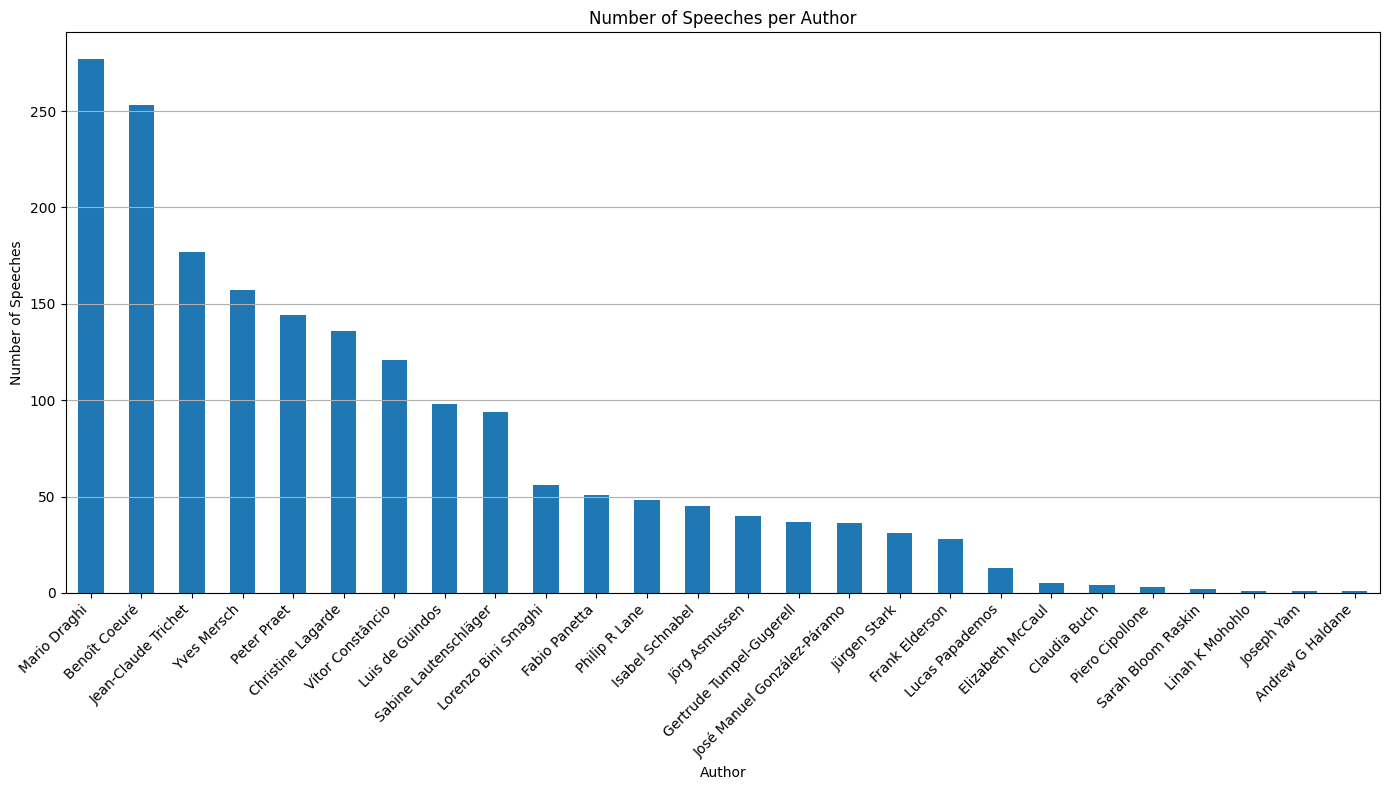

In [116]:
# Count number of speeches per author
speeches_per_author = speeches['speaker_name'].value_counts()

# Bar chart for number of speeches per author
plt.figure(figsize=(14, 8))
speeches_per_author.plot(kind='bar')
plt.title("Number of Speeches per Author")
plt.xlabel("Author")
plt.ylabel("Number of Speeches")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##### Gender representation over time

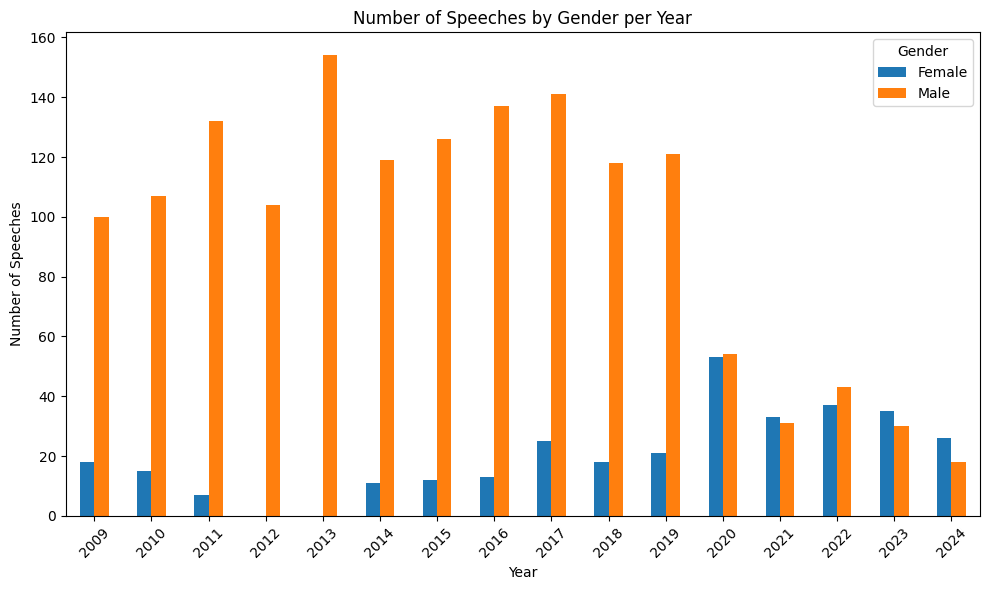

In [117]:
# Group by year and gender and count the number of speeches
gender_counts = speeches.groupby(['year', 'gender']).size().unstack(fill_value=0)
gender_counts.plot(kind='bar', stacked=False, figsize=(10, 6))

plt.title('Number of Speeches by Gender per Year')
plt.xlabel('Year')
plt.ylabel('Number of Speeches')
plt.xticks(rotation=45)
plt.legend(title='Gender', labels=['Female', 'Male'])
plt.tight_layout()
plt.show()


The gender representation trend provides insights into the diversity of speakers over time : we observe a clear augmentation of women speakers in 2020, which coincides with Christine Lagarde's arrival at the presidence of the BCE. It also coincides with a drop in the toal number of speeches per year, men and women together. 

From the previous graph, we also know that she is the top woman speaker in our dataset.

##### Speeches length analysis

C:\Users\marie\AppData\Local\Temp\ipykernel_39564\564794865.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



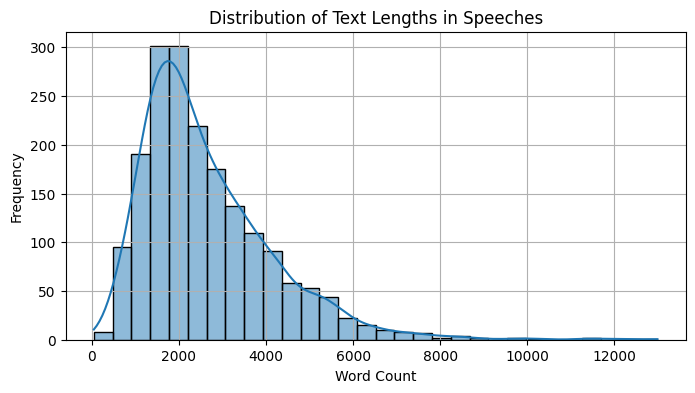

In [118]:
# Word count for each speech
speeches['text_length'] = speeches['speech_content'].apply(lambda x: len(str(x).split()))

# Distribution of text lengths
plt.figure(figsize=(8, 4))
sns.histplot(speeches['text_length'], bins=30, kde=True)
plt.title("Distribution of Text Lengths in Speeches")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

The histogram of speech lengths helps us understand the variability in content richness.

#### Topic exploration, to get a global idea of what topics the speeches treat of

- Word Frequency Analysis and Word Cloud Visualization using word counts and TFIDF Vectorizer

In [119]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Combine all speeches into one text
all_text = " ".join(speeches['speech_content'].dropna())

# Normalize to lowercase and count word frequencies
words = [word.lower() for word in all_text.split()]
word_counts = Counter(words)

# Filter out common stopwords (in english)
stop_words = set(stopwords.words("english"))
filtered_word_counts = {word: count for word, count in word_counts.items() if word not in stop_words}

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [120]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    stop_words="english",
    min_df=15,
    max_df=0.8, # not appear in more than 80% of the doc
    ngram_range=(1, 3),
    token_pattern=r"\b[a-zA-Z]{4,}\b", # removes numbers
)
X_ = vectorizer.fit_transform(speeches["speech_content"].values)
cols = vectorizer.get_feature_names_out()

To reduce the impact over large  `tfidf` coefficients, we use the log transformationl $x \mapsto log(1+x)$ 

In [121]:
tfidf_matrix = X_.toarray() # convert the TF-IDF matrix as a dense array
X_tfidf = pd.DataFrame(np.log1p(tfidf_matrix), index=speeches["speech_content"].index, columns=cols)

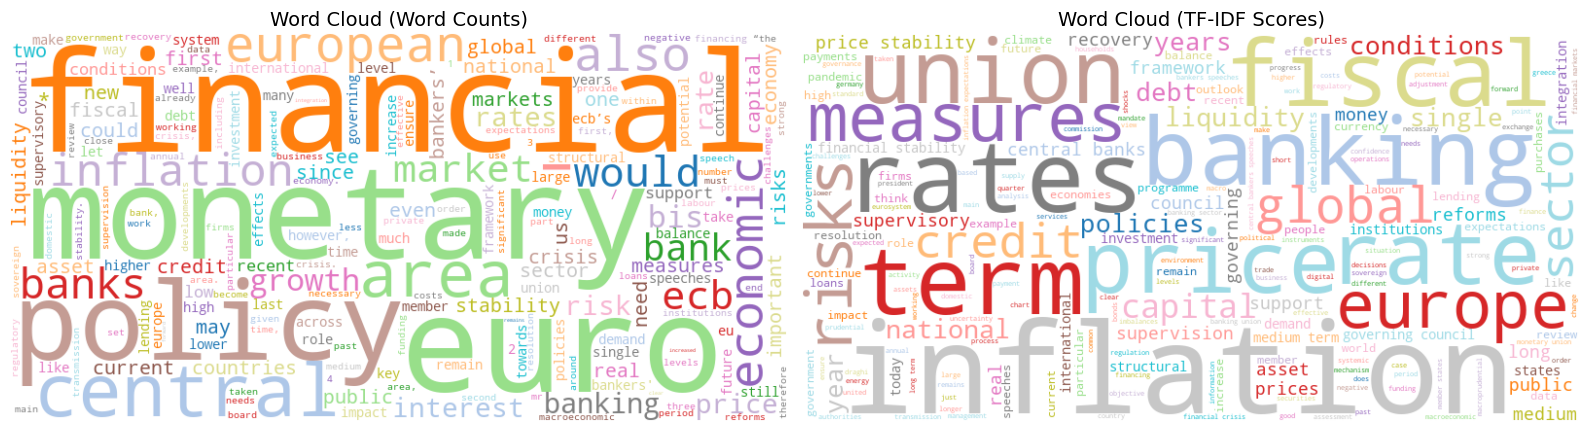

In [122]:
from wordcloud import WordCloud

# generate WordCloud according to word counts
wordcloud_counts = WordCloud(width=800, height=400, background_color="white", colormap='tab20').generate_from_frequencies(filtered_word_counts)

# generate WordCloud according to TF-IDF scores
# Calculate the sum of the TF-IDF scores for each term across all speeches
sum_tfidf_scores = tfidf_matrix.sum(axis=0)
# Create a dictionary with words as keys and their total TF-IDF score as values
word_freq = dict(zip(cols, sum_tfidf_scores))
wordcloud_tfidf = WordCloud(width=800, height=400, background_color="white", colormap='tab20').generate_from_frequencies(word_freq)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Word Cloud for Word Counts
axes[0].imshow(wordcloud_counts, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("Word Cloud (Word Counts)", fontsize=14)

# Word Cloud for TF-IDF Scores
axes[1].imshow(wordcloud_tfidf, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("Word Cloud (TF-IDF Scores)", fontsize=14)

plt.tight_layout()
plt.show()


Separate speeches from men and women speakers

In [123]:
speeches_men = speeches[speeches['gender']=='male']
speeches_women = speeches[speeches['gender']=='female']
print(f'Number of speeches by men: {len(speeches_men)}')
print(f'Number of speeches by women : {len(speeches_women)}')

Number of speeches by men: 1535
Number of speeches by women : 324


We can see that the women's dataset is much smaller than the men's. This raises questions about statistical validity:
If we try to compare trends or characteristics between male and female speakers, the smaller sample size for women might lead to less reliable conclusions.

### ANALYTICS AND LEARNING STRATEGY

The analytics and machine learning methodologies section accounts for:

- A detailed explanation of the foundational algorithm.

- A description of the data partitioning strategy for training, validation and test.

- An overview of the parameter selection and optimization process.

We want to lead two distinct analysis : 
- Topic Modeling by Gender, using Latent Dirichlet Allocation (LDA) technique and NMF? to identify dominant topics in speeches by men and women.
- Sentiment Analysis by Gender, using Loughran McDonald's to examine sentiment /tone differences for both genders

### Sentiment Analysis

In [23]:
from skfin.plot import line
from skfin.text import coefs_plot, show_text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#### 1st approach : Loughran-McDonals sentiment lexicon
English sentiment lexicon created for use with financial documents. This lexicon labels words with six possible sentiments important in financial contexts: "negative", "positive", "litigious", "uncertainty", "constraining", or "superfluous".

In [75]:
logger = logging.getLogger(__name__)

def load_loughran_mcdonald_dictionary(cache_dir="data", force_reload=False):
    """
    Loads the Loughran-McDonald Master Dictionary.
    If the file doesn't exist locally, downloads it from the external source.
    
    Parameters:
        cache_dir (str): Directory to cache the file.
        force_reload (bool): Whether to force downloading the file again.
    
    Returns:
        pd.DataFrame: Loaded dictionary as a DataFrame.
    """
    # Ensure the cache directory exists
    cache_dir = Path(cache_dir)
    cache_dir.mkdir(parents=True, exist_ok=True)
    
    # Filepath for the dictionary
    filename = cache_dir / "Loughran-McDonald_MasterDictionary_1993-2021.csv"
    
    if filename.exists() and not force_reload:
        logger.info(f"Loading from cache file: {filename}")
    else:
        logger.info("Loading from external source")
        id = "17CmUZM9hGUdGYjCXcjQLyybjTrcjrhik"
        url = f"https://docs.google.com/uc?export=download&id={id}"
        
        try:
            # Download file using requests
            response = requests.get(url, stream=True)
            response.raise_for_status()  # Raise an error for bad HTTP status codes
            
            with open(filename, "wb") as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            logger.info(f"Downloaded file to {filename}")
        except requests.RequestException as e:
            logger.error(f"Error downloading file: {e}")
            raise
    
    # Ensure the file exists after the operation
    if not filename.exists():
        raise FileNotFoundError(f"Failed to download file: {filename}")
    
    # Load the CSV file into a DataFrame
    return pd.read_csv(filename)

lm = load_loughran_mcdonald_dictionary()

INFO:__main__:Loading from cache file: data\Loughran-McDonald_MasterDictionary_1993-2021.csv


In [84]:
# Filter the dictionary for relevant sentiment categories
sentiment_categories = ['Positive', 'Negative', 'Uncertainty', 'Litigious', 'Constraining']
lm_sentiment_words = lm[['Word'] + sentiment_categories].set_index('Word').fillna(0)

In [80]:
lm[['Word'] + sentiment_categories].set_index('Word').fillna(0)

,Positive,Negative,Uncertainty,Litigious,Constraining
Word,,,,,
AARDVARK,0,0,0,0,0
AARDVARKS,0,0,0,0,0
ABACI,0,0,0,0,0
ABACK,0,0,0,0,0
ABACUS,0,0,0,0,0
...,...,...,...,...,...
ZYGOTE,0,0,0,0,0
ZYGOTES,0,0,0,0,0
ZYGOTIC,0,0,0,0,0


In [85]:
def calculate_sentiment(tokens):
    scores = {category: 0 for category in sentiment_categories}
    
    for token in tokens:
        if token.upper() in lm_sentiment_words.index:
            for category in sentiment_categories:
                scores[category] += lm_sentiment_words.loc[token.upper(), category]
    
    return scores

# Apply to the dataset
speeches['sentiment_scores_lmd'] = speeches['cleaned_speech_tokens'].apply(calculate_sentiment)


In [87]:
# Extract sentiment scores into separate columns
for category in sentiment_categories:
    speeches[f'{category.lower()}_score'] = speeches['sentiment_scores_lmd'].apply(lambda x: x[category])

# Normalize by token count
speeches['token_count'] = speeches['cleaned_speech_tokens'].apply(len)
for category in sentiment_categories:
    speeches[f'{category.lower()}_normalized'] = speeches[f'{category.lower()}_score'] / speeches['token_count']


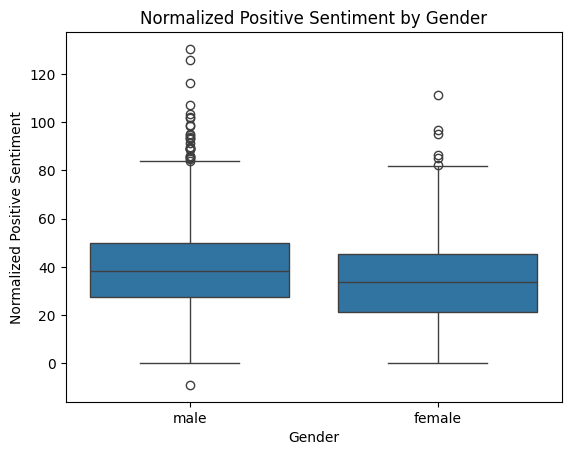

In [88]:

# Compare normalized positive scores by gender
sns.boxplot(x='gender', y='positive_normalized', data=speeches)
plt.title("Normalized Positive Sentiment by Gender")
plt.xlabel("Gender")
plt.ylabel("Normalized Positive Sentiment")
plt.show()

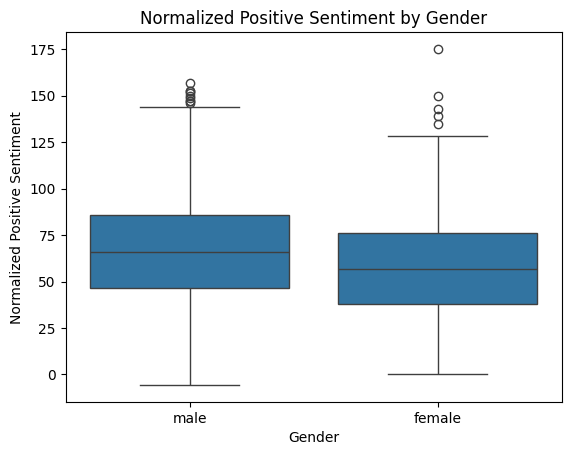

In [89]:

# Compare normalized positive scores by gender
sns.boxplot(x='gender', y='negative_normalized', data=speeches)
plt.title("Normalized Positive Sentiment by Gender")
plt.xlabel("Gender")
plt.ylabel("Normalized Positive Sentiment")
plt.show()

In [26]:
X_men = speeches_men['speech_content']
X_women = speeches_women['speech_content']
funcs = {
    "negative": lambda x: x.Negative > 0,
    "positive": lambda x: x.Positive > 0,
    "all": lambda x: x.Word.notna(),
}

def get_total_count(X, lm, func):
    m = CountVectorizer(vocabulary=lm.loc[func].Word.str.lower().values)
    return pd.DataFrame(m.fit_transform(X).toarray(), index=X.index).sum(axis=1)


lm_counts_men = pd.concat({k: get_total_count(X_men, lm, v) for k, v in funcs.items()}, axis=1)
lm_counts_women = pd.concat({k: get_total_count(X_women, lm, v) for k, v in funcs.items()}, axis=1)

C:\Users\marie\AppData\Local\Temp\ipykernel_39532\373263289.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




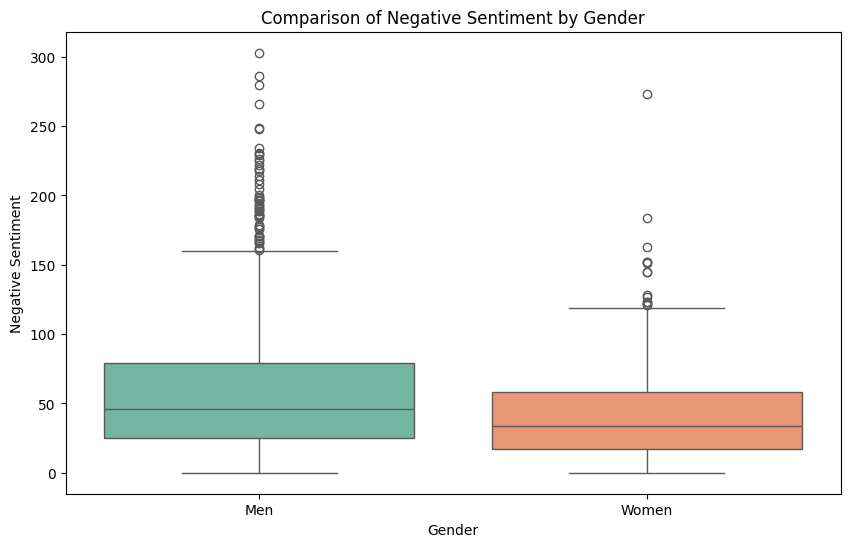

C:\Users\marie\AppData\Local\Temp\ipykernel_39532\373263289.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




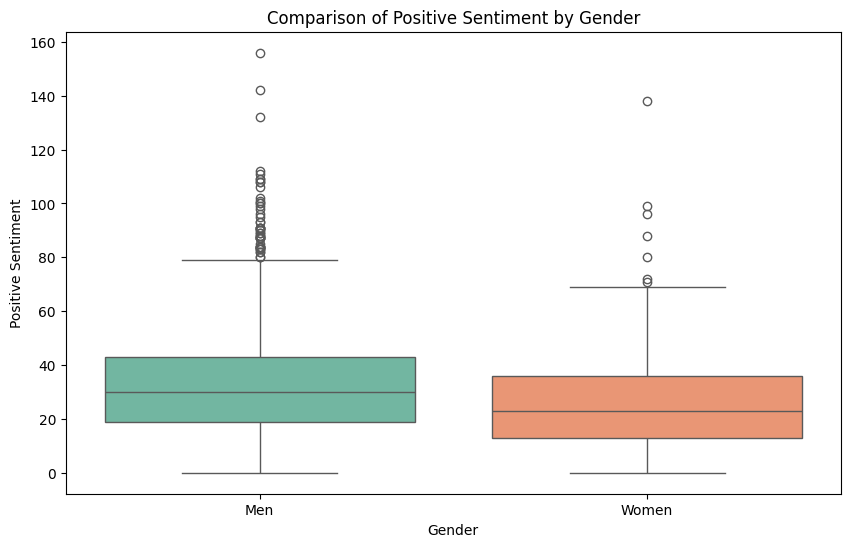

In [ ]:
lm_counts_men['date'] = pd.to_datetime(speeches_men['converted_date'])
lm_counts_men = lm_counts_men.set_index('date')
lm_counts_women['date'] = pd.to_datetime(speeches_women['converted_date'])
lm_counts_women = lm_counts_women.set_index('date')
lm_counts_men['gender'] = 'Men'
lm_counts_women['gender'] = 'Women'
lm_counts_combined = pd.concat([lm_counts_men, lm_counts_women])

# Negative
plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='negative', data=lm_counts_combined, palette="Set2")
plt.title("Comparison of Negative Sentiment by Gender")
plt.xlabel("Gender")
plt.ylabel("Negative Sentiment")
plt.show()

# Positive
plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='positive', data=lm_counts_combined, palette="Set2")
plt.title("Comparison of Positive Sentiment by Gender")
plt.xlabel("Gender")
plt.ylabel("Positive Sentiment")
plt.show()


Men : higher median in both negative and postive sentiments : Men's speeches are more emotionally charged, men’s speeches may cover a wider emotional spectrum, reflecting a tendency to express contrasting sentiments more frequently or strongly.

A higher median for negative sentiment suggests men might be more critical, pessimistic, or focused on challenges in their speeches.
A higher median for positive sentiment implies they may also emphasize optimism or solutions more often.
Men might adopt a more assertive or persuasive tone, which could involve emphasizing both problems and resolutions more explicitly.


In [ ]:
# Filter speeches after 2020 for better readability
date_filter = "2024-01-01" #"2020-01-01"
lm_counts_men_filtered = lm_counts_men[lm_counts_men.index >= date_filter]
lm_counts_women_filtered = lm_counts_women[lm_counts_women.index >= date_filter]

# Calculate sentiment score for women and men after 2020
sentiment_women = (
    lm_counts_women_filtered.pipe(lambda x: (x.positive - x.negative) / x["all"])
    .resample("B")
    .last()
    .ffill()
)
sentiment_men = (
    lm_counts_men_filtered.pipe(lambda x: (x.positive - x.negative) / x["all"])
    .resample("B")
    .last()
    .ffill()
)

fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.1,
    subplot_titles=["Sentiment Over Time (After 2020): Men", "Sentiment Over Time (After 2020): Women"],
)

# Men's sentiment
fig.add_trace(
    go.Scatter(
        x=sentiment_men.index,
        y=sentiment_men,
        mode='lines+markers',
        name="Men's Sentiment",
        line=dict(color='blue', width=1.5),
        marker=dict(size=4),
        showlegend=False,
    ),
    row=1, col=1
)
# Women's sentiment
fig.add_trace(
    go.Scatter(
        x=sentiment_women.index,
        y=sentiment_women,
        mode='lines+markers',
        name="Women's Sentiment",
        line=dict(color='red', width=1.5),
        marker=dict(size=4),
        showlegend=False
    ),
    row=2, col=1
)

fig.update_layout(
    title="Sentiment Analysis Over Time (After 2020)",
    yaxis_title="Sentiment Score",
    xaxis=dict(showgrid=True, tickangle=45),
    yaxis=dict(showgrid=True),
    template="plotly_white",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)
fig.show()


For better readability, we focus on the 2020-2024 period, which is also th eperiod where the amount of men vswomen speeches is more equilibré. 

2nd approach : There are few transformers algo to treat sentiment analysis for long texts 

2: With transformers
preprocess the text first to remove stop words, punctuation, special characters etc.

In [44]:
import re
import string
# nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)     # Remove URLs
    text = re.sub(r'@\w+', '', text)    # Remove mentions (e.g., @user)
    text = re.sub(r'[^a-zA-Z\s]', '', text)    # Remove special characters and numbers
    text = ' '.join([word for word in text.split() if word not in stop_words])     # Tokenize the text and remove stopwords
    text = ' '.join(text.split()) # Remove extra whitespace
    return text

# Apply preprocessing
speeches['processed_content'] = speeches['speech_content'].apply(preprocess_text)

# Display the length of the original and processed text
speeches['original_length'] = speeches['speech_content'].apply(len)
speeches['processed_length'] = speeches['processed_content'].apply(len)

# speeches[['speech_content', 'processed_content', 'original_length', 'processed_length']].head()

C:\Users\marie\AppData\Local\Temp\ipykernel_39564\2623847524.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\marie\AppData\Local\Temp\ipykernel_39564\2623847524.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\marie\AppData\Local\Temp\ipykernel_39564\2623847524.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

distilbert/distilbert-base-uncased-finetuned-sst-2-english + only first 512 tokens

In [ ]:
# from transformers import pipeline

# # Load sentiment analysis model
# sentiment_pipeline = pipeline("sentiment-analysis")

# # Apply the model
# speeches['sentiment'] = speeches['processed_content'].apply(lambda x: sentiment_pipeline(x[:512])[0]['label'])  # Limit to first 512 tokens


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
# speeches[['speech_content', 'processed_content', 'sentiment']].head()

speech_content  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Jean-Claude Trichet: Ten years of the euro – successes and challenges\nSpeech by Mr Jean-Claude Trichet, President of the Europ

In [106]:
# Create a FacetGrid with gender as a facet and normalize to proportions
# g = sns.FacetGrid(speeches, col='gender', height=5, aspect=1.5)
# g.map(sns.histplot, 'sentiment', bins=30, kde=True, stat='probability')

# g.set_axis_labels("Sentiment Score", "Proportion")
# g.set_titles("{col_name}")
# plt.show()


In [ ]:
# empty speeches
speeches[speeches['processed_content'].str.strip() == ""]

,id,path,menu_id,short_title,long_title,publication_start_date,language,pdf_file_size,pdf_pages,has_content,...,speaker_gender,converted_date,year,year_month,text_length,processed_content,original_length,processed_length,sentiment,token_length
1113,22179,/review/r170512e.pdf,60,Vítor Constâncio: Macroprudential policy in a changing financial system,"<p>Remarks by Mr Vítor Constâncio, Vice-President of the European Central Bank, at the second ECB Macroprudential Policy and Research Conference, Frankfurt am Main, 11 May 2017.</p>",2017-05-12T04:06:00.000+02:00,en,2366,9,True,...,Male,2017-05-12 02:06:00+00:00,2017,2017-05,0,,0,0,sentiment sentiment sentiment:,2
1650,31317,/review/r210714c.pdf,60,Isabel Schnabel: A new strategy for a changing world,"<p>Speech by Ms Isabel Schnabel, Member of the Executive Board of the European Central Bank, at a virtual event series, hosted by the Peterson Institute for International Economics, 14 July 2021.</p>",2021-07-14T00:00:00.000+02:00,en,3036,10,True,...,Female,2021-07-13 22:00:00+00:00,2021,2021-07,0,,0,0,sentiment sentiment sentiment:,2
1707,32134,/review/r220223o.pdf,60,"Fabio Panetta: Central bank digital currencies - defining the problems, designing the solutions","<p>Contribution by Mr Fabio Panetta, Member of the Executive Board of the European Central Bank, to a panel discussion on central bank digital currencies at the US Monetary Policy Forum, New York City, 18 February 2022.</p>",2022-02-23T00:00:00.000+01:00,en,3113,8,True,...,Male,2022-02-22 23:00:00+00:00,2022,2022-02,0,,0,0,sentiment sentiment sentiment:,2
1714,32221,/review/r220317b.pdf,60,"Isabel Schnabel: A new age of energy inflation - climateflation, fossilflation and greenflation","<p>Speech by Ms Isabel Schnabel, Member of the Executive Board of the European Central Bank, at a panel on ""Monetary policy and climate change"" at ""The ECB and Its Watchers XXII"" Conference, Frankfurt am Main, 17 March 2022.</p>",2022-03-17T00:00:00.000+01:00,en,2937,8,True,...,Female,2022-03-16 23:00:00+00:00,2022,2022-03,0,,0,0,sentiment sentiment sentiment:,2
1838,34815,/review/r230830b.pdf,60,Christine Lagarde: Policymaking in an age of shifts and breaks,"<p>Speech by Ms Christine Lagarde, President of the European Central Bank, at ""Structural Shifts in the Global Economy"", an economic policy symposium sponsored by the Federal Reserve Bank of Kansas City, Jackson Hole, Wyoming, 25 August 2023.</p>",2023-08-30T10:30:00.000+02:00,en,3030,12,True,...,Female,2023-08-30 08:30:00+00:00,2023,2023-08,0,,0,0,sentiment sentiment sentiment:,2
1839,34816,/review/r230717b.pdf,60,Christine Lagarde: Strengthening resilience in a changing geopolitical landscape,"<p>Welcome address by Ms Christine Lagarde, President of the European Central Bank, at the 9th ECB conference on central, eastern and south-eastern European countries, Frankfurt am Main, 17 July 2023.</p>",2023-07-17T10:00:00.000+02:00,en,1334,6,True,...,Female,2023-07-17 08:00:00+00:00,2023,2023-07,0,,0,0,sentiment sentiment sentiment:,2


longformer

In [ ]:
# Check for empty or null strings
empty_speeches = speeches[speeches['processed_content'].str.strip() == ""]
print(f"Number of empty speeches: {len(empty_speeches)}")
speeches = speeches[speeches['processed_content'].str.strip() != ""]

Number of empty speeches: 6


In [48]:
speeches['token_length']

0         6008
1         6663
2         2499
3         4551
4         2370
         ...  
1959     84809
1960    310624
1961      3693
1962     45087
1963      1720
Name: token_length, Length: 1964, dtype: int64

In [ ]:
from transformers import LongformerTokenizer
from transformers import pipeline



# Initialize the tokenizer for Longformer
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")
# Load Longformer for sentiment analysis
sentiment_pipeline = pipeline("sentiment-analysis", model="allenai/longformer-base-4096")

# Apply tokenization to speech content and check length
speeches['token_length'] = speeches['processed_content'].apply(lambda x: len(tokenizer.encode(x)))

# Compare lengths of the processed speeches and the tokenized speeches
print(speeches[['processed_length', 'token_length']].head())

In [ ]:
# Apply sentiment analysis
speeches['sentiment_longformer'] = speeches['processed_content'].apply(lambda x: sentiment_pipeline(x)[0]['label'])


Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Initializing global attention on CLS token...
Input ids are automatically padded to be a multiple of `config.attention_window`: 512


IndexError: index out of range in self

In [ ]:



# to deal with long texts / too many tokens

T5 - needs lots of work

In [41]:
from transformers import pipeline

# Load the pre-trained T5 model for sentiment analysis
sentiment_pipeline = pipeline("text2text-generation", model="t5-small")

# Apply sentiment analysis
speeches['sentiment'] = speeches['processed_content'].apply(lambda x: sentiment_pipeline(f"sentiment: {x[:512]}")[0]['generated_text'])


c:\Users\marie\OneDrive\Documents\cours\ensae\3A\ML for portfolio management\.venvML\Lib\site-packages\transformers\generation\utils.py:1375: UserWarning:

Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.



In [53]:
speeches['sentiment'].unique()

array(['jeanclaude trichet ten years euro successes challenges speech mr',
       'lucas papademos vice president european central bank annual dinner society business economists ',
       'jeanclaude trichet president european central bank annual joint parliamentary meeting european',
       ...,
       'christine lagarde welcome address tenth anniversary single supervisory mechanism welcome address ',
       'luis de guindos financial stability euro area speech mr luis de',
       'elizabeth mccaul member supervisory board european central bank european banking'],
      dtype=object)

In [54]:
# Count sentiment frequencies
sentiment_counts = speeches['sentiment'].value_counts()
sentiment_counts


sentiment
cidcidcidcidcidcidcidcidcidcidcidcidcidcidcidcidcidcidcid                                                 96
mario draghi ecb press conference introductory statement introductory statement m                         33
mario draghi hearing committee economic monetary affairs european parliament introductory statement mr    30
christine lagarde president european central bank mr luis de guind                                        27
mario draghi ecb press conference introductory statement mr mario                                         24
                                                                                                          ..
elizabeth mccaul beyond spotlight using peripheral vision better supervision speech                        1
christine lagarde welcome address fifth european central bank forum banking supervision speech ms          1
luis de guindos vicepresident european central bank th edition spain                                       1
luis de g

Custom Sentiment Models: Fine-tune a transformer model like BERT on a labeled dataset specific to central bank language.

 a long and structured text may probably contain segments of "positive" sentiment along with "negative" ones, it can be infinitely more subtle and nuanced, and in principle trying to simply label it overall as "positive/negative" (or even adding a couple more sentiment categories) is futile, unproductive, and at the end of the day hardly useful.

 If you read a long text, there might be several different subjects and several different sentiments about each subject to be estimated.

### Topic Modeling

Preprocess speeches

In [ ]:
# !python -m spacy download en_core_web_sm

In [124]:
# clean and preprocess speech contents
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')  
nltk.download('omw-1.4')  
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# remove stopwords, punctuation, and normalize the corpus
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer() # initializes WordNetLemmatizer object to perform lemmatization

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = "".join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

# cleaned text as list of words instead of a string
speeches['cleaned_speech_tokens'] = speeches['speech_content'].apply(lambda doc: clean(doc).split())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\marie\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
C:\Users\marie\AppData\Local\Temp\ipykernel_39564\160083990.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [125]:
import spacy
from nltk.corpus import stopwords

# Load a spaCy model for lemmatization
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# preprocessing function
def preprocess_text(text):
    doc = nlp(text.lower())  # Convert text to lowercase and tokenize
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

# Apply the function to your dataset
# speeches['processed_content_topic_modeling'] = speeches['speech_content'].apply(preprocess_text)
speeches['processed_content_topic_modeling'] = speeches['speech_content'].apply(lambda doc: preprocess_text(doc).split())

# # Display the first few rows to verify
speeches[['processed_content_topic_modeling', 'cleaned_speech_tokens']].head()

# 32min
# 40 min

C:\Users\marie\AppData\Local\Temp\ipykernel_39564\4086920960.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,processed_content_topic_modeling,cleaned_speech_tokens
0,"[jean, claude, trichet, year, euro, success, c...","[jeanclaude, trichet, ten, year, euro, –, succ..."
1,"[lucas, papademos, tackle, financial, crisis, ...","[lucas, papademos, tackling, financial, crisis..."
2,"[jean, claude, trichet, macroeconomic, policy,...","[jeanclaude, trichet, macroeconomic, policy, i..."
3,"[lorenzo, bini, smaghi, regulation, supervisor...","[lorenzo, bini, smaghi, regulation, supervisor..."
4,"[jean, claude, trichet, interview, china, fina...","[jeanclaude, trichet, interview, china, financ..."


In [128]:
speeches['cleaned_speech_tokens_length'] = speeches['cleaned_speech_tokens'].apply(len)
speeches['processed_content_topic_modeling_length'] = speeches['processed_content_topic_modeling'].apply(len)

speeches[['processed_content_topic_modeling','cleaned_speech_tokens','processed_content_topic_modeling_length','cleaned_speech_tokens_length' ]].head()

C:\Users\marie\AppData\Local\Temp\ipykernel_39564\3118808253.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\marie\AppData\Local\Temp\ipykernel_39564\3118808253.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,processed_content_topic_modeling,cleaned_speech_tokens,processed_content_topic_modeling_length,cleaned_speech_tokens_length
0,"[jean, claude, trichet, year, euro, success, c...","[jeanclaude, trichet, ten, year, euro, –, succ...",2353,2600
1,"[lucas, papademos, tackle, financial, crisis, ...","[lucas, papademos, tackling, financial, crisis...",2701,2916
2,"[jean, claude, trichet, macroeconomic, policy,...","[jeanclaude, trichet, macroeconomic, policy, i...",987,1057
3,"[lorenzo, bini, smaghi, regulation, supervisor...","[lorenzo, bini, smaghi, regulation, supervisor...",1728,1891
4,"[jean, claude, trichet, interview, china, fina...","[jeanclaude, trichet, interview, china, financ...",892,986


##### LDA : 
LDA is a generative probabilistic model that assumes documents are mixtures of topics, and topics are mixtures of words.

with document-term matrix

In [ ]:
from gensim import corpora
from gensim.models import LdaModel

# # Create the document-term matrix
dictionary = corpora.Dictionary(speeches['cleaned_speech_tokens'])
doc_term_matrix = [dictionary.doc2bow(doc) for doc in speeches['cleaned_speech_tokens']]

# LDA model
lda = LdaModel(corpus=doc_term_matrix, num_topics=8, id2word = dictionary, passes=10)
topics = lda.print_topics(num_topics=8, num_words=7)
for i, topic in topics:
    print(f"Topic {i}: {topic}")

# # Create the document-term matrix
dictionary2 = corpora.Dictionary(speeches['processed_content_topic_modeling'])
doc_term_matrix2 = [dictionary2.doc2bow(doc) for doc in speeches['processed_content_topic_modeling']]

# LDA model
lda2 = LdaModel(corpus=doc_term_matrix2, num_topics=8, id2word = dictionary2, passes=10)
topics2 = lda2.print_topics(num_topics=8, num_words=7)
for i, topic in topics2:
    print(f"Topic {i}: {topic}")


[(0, '0.017*"bank" + 0.015*"financial" + 0.015*"policy"'),
 (4, '0.009*"bank" + 0.008*"central" + 0.008*"policy"'),
 (7, '0.007*"t2s" + 0.005*"market" + 0.005*"bank"')]

Topic 0: 0.018*"policy" + 0.016*"inflation" + 0.014*"rate"
Topic 1: 0.013*"euro" + 0.013*"bank" + 0.012*"european"
Topic 2: 0.021*"bank" + 0.019*"risk" + 0.014*"climate"
Topic 3: 0.027*"financial" + 0.017*"bank" + 0.014*"risk"
Topic 4: 0.014*"policy" + 0.012*"bank" + 0.011*"monetary"
Topic 5: 0.042*">" + 0.034*"<" + 0.032*"="
Topic 6: 0.022*"payment" + 0.013*"market" + 0.011*"central"
Topic 7: 0.009*"bank" + 0.008*"rate" + 0.006*"market"


Topic 1:
['policy', 'inflation', 'rate', 'monetary', 'area', 'euro', 'bank', 'economic', 'term', 'growth']



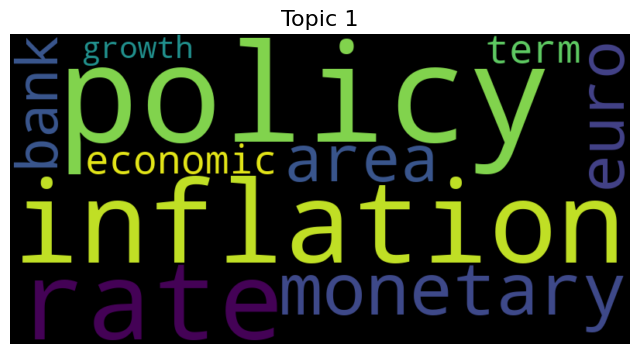

Topic 2:
['euro', 'bank', 'european', 'area', 'country', 'market', 'central', 'financial', 'crisis', 'union']



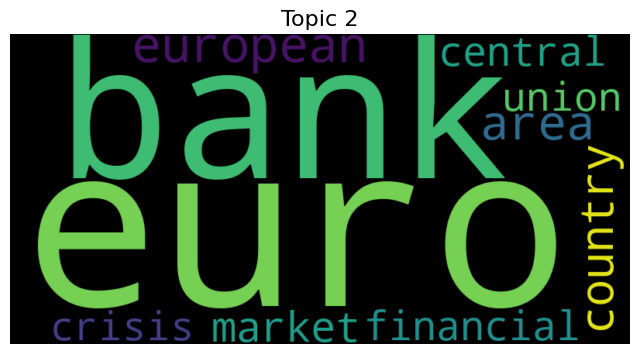

Topic 3:
['bank', 'risk', 'climate', 'ecb', 'central', 'change', 'european', 'supervisory', 'supervision', 'green']



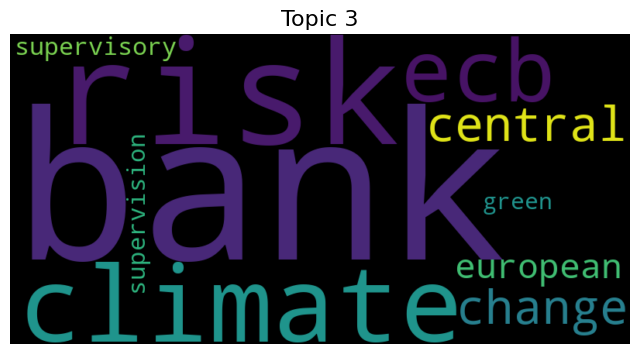

Topic 4:
['financial', 'bank', 'risk', 'policy', 'market', 'crisis', 'central', 'stability', 'system', 'banking']



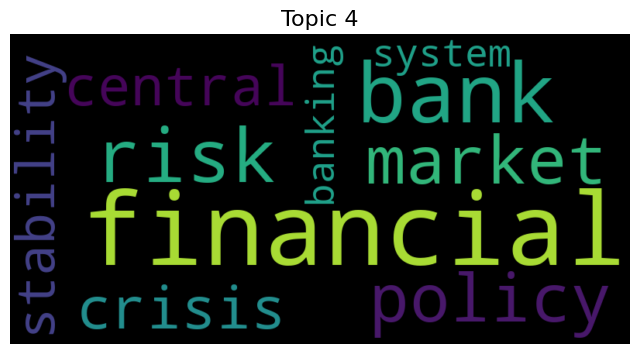

Topic 5:
['policy', 'bank', 'monetary', 'ecb', 'euro', 'rate', 'central', 'area', 'price', 'market']



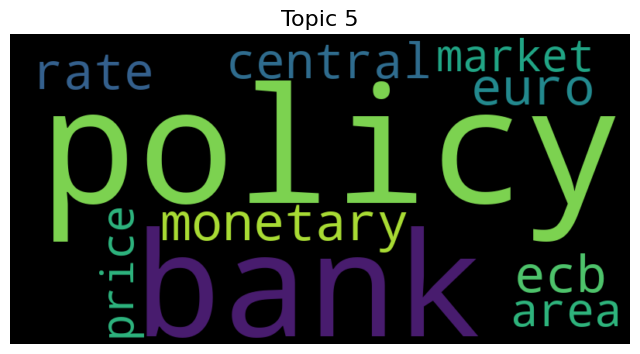

Topic 6:
['>', '<', '=', '$', '+', '=(', 'euro', 'area', 'cid:0)(cid:2)(cid:3)(cid:3)(cid:4)(cid:5', 'f']



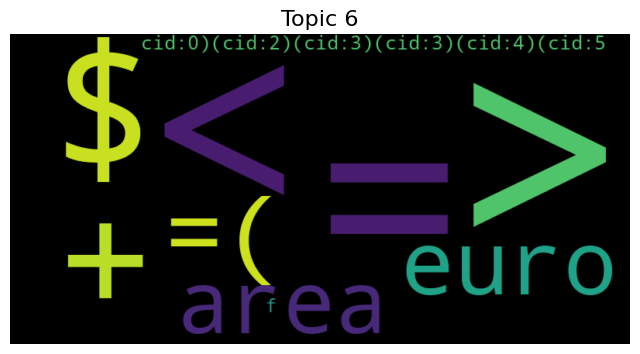

Topic 7:
['payment', 'market', 'central', 'bank', 'euro', 'digital', 'european', 'service', 'financial', 'ccp']



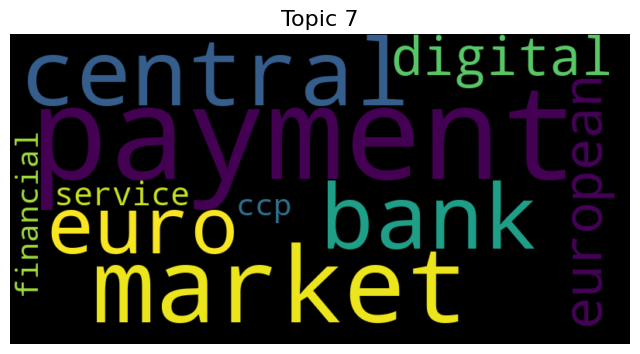

Topic 8:
['bank', 'rate', 'market', 'policy', 'inflation', 'reserve', 'interest', 'central', 'excess', 'ecb']



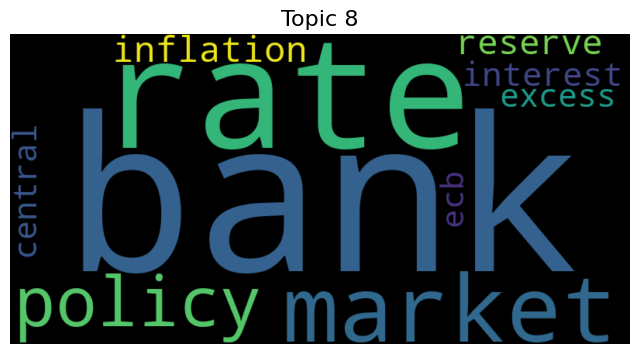

In [80]:
# display the top words + wordcloud for each topic
num_topics = lda.num_topics

for topic_id in range(num_topics):
    # Get the top 10 words for each topic
    top_words = lda.show_topic(topic_id, topn=10)
    print(f"Topic {topic_id + 1}:")
    print([word for word, prob in top_words])  # Extract just the words
    print()

    # wordcloud
    words = dict(lda.show_topic(topic_id, topn=10))  # Get top 20 words for the topic
    wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(words)
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Topic {topic_id + 1}", fontsize=16)
    plt.axis("off")
    plt.show()

In [82]:
from gensim.models import CoherenceModel

# Compute coherence score for the LDA model
coherence_model_lda = CoherenceModel(model=lda, texts=speeches['cleaned_speech_tokens'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f"Coherence Score: {coherence_lda}")


Coherence Score: nan


In [ ]:
# print(f"Coherence Score: {coherence_lda}")
# # 5 topics : 0.337
# # 8 topics : 0.377


# 0.352

Coherence Score: 0.3526581597225114


Compare topic "distribution" among genders

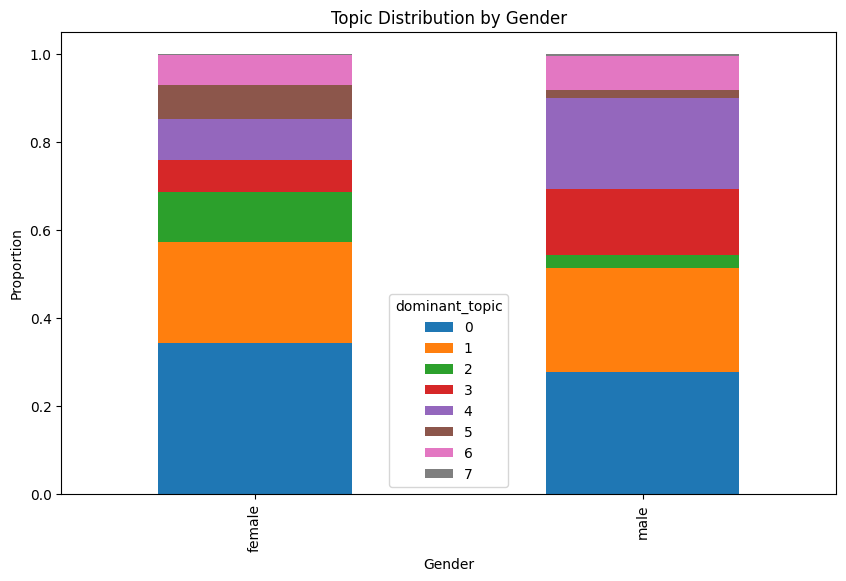

In [83]:
# Assign the dominant topic for each speech
speeches['dominant_topic'] = [max(lda[doc], key=lambda x: x[1])[0] for doc in doc_term_matrix]

# Analyze topic distribution by gender
topic_by_gender = speeches.groupby(['gender', 'dominant_topic']).size().unstack().fillna(0)
topic_by_gender = topic_by_gender.div(topic_by_gender.sum(axis=1), axis=0)

# Plot topic distribution by gender
topic_by_gender.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Topic Distribution by Gender")
plt.xlabel("Gender")
plt.ylabel("Proportion")
plt.show()


In [84]:
# speeches['processed_content_topic_modeling_length'] = speeches['processed_content_topic_modeling'].apply(len)
# speeches[['speech_content', 'processed_content', 'processed_content_topic_modeling','cleaned_speech_tokens', 'original_length', 'processed_length', 'processed_content_topic_modeling_length']].head()

with TFIDF

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora
from gensim.models import LdaModel

# Step 1: Generate the TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)  # Limit the vocabulary size
tfidf_matrix = tfidf_vectorizer.fit_transform(speeches['processed_content_topic_modeling'])

# Step 2: Create a Gensim dictionary from the TF-IDF vocabulary
# The vocabulary from the TF-IDF Vectorizer is used to map terms to IDs
tfidf_vocab = tfidf_vectorizer.get_feature_names_out()
gensim_dictionary = corpora.Dictionary([tfidf_vocab])

# Step 3: Convert the TF-IDF matrix to a Gensim corpus format
# Each document is a list of (term_id, tfidf_value) tuples
gensim_corpus_tfidf = [
    [(term_id, tfidf_value) for term_id, tfidf_value in zip(tfidf_matrix.getrow(doc_idx).indices, tfidf_matrix.getrow(doc_idx).data)]
    for doc_idx in range(tfidf_matrix.shape[0])
]

# Step 4: Train the LDA model using the TF-IDF-based corpus
lda_tfidf = LdaModel(corpus=gensim_corpus_tfidf, num_topics=8, id2word=gensim_dictionary, passes=10)

# Step 5: Print the topics
topics_tfidf = lda_tfidf.print_topics(num_topics=8, num_words=5)
for i, topic in topics_tfidf:
    print(f"Topic {i}: {topic}")


Topic 0: 0.013*"statistic" + 0.008*"financial" + 0.007*"datum" + 0.006*"prudential" + 0.006*"macro"
Topic 1: 0.045*"sepa" + 0.032*"card" + 0.019*"payment" + 0.006*"scheme" + 0.005*"retail"
Topic 2: 0.011*"bank" + 0.011*"euro" + 0.009*"european" + 0.008*"area" + 0.008*"financial"
Topic 3: 0.008*"policy" + 0.008*"inflation" + 0.006*"monetary" + 0.004*"cid" + 0.004*"rate"
Topic 4: 0.021*"inflation" + 0.012*"growth" + 0.011*"euro" + 0.011*"area" + 0.011*"monetary"
Topic 5: 0.238*"cid" + 0.035*"climate" + 0.008*"risk" + 0.008*"green" + 0.007*"bank"
Topic 6: 0.003*"policy" + 0.003*"euro" + 0.003*"bank" + 0.003*"area" + 0.003*"monetary"
Topic 7: 0.012*"policy" + 0.011*"bank" + 0.009*"financial" + 0.008*"monetary" + 0.008*"market"


Topic 1:
['statistic', 'financial', 'datum', 'prudential', 'macro', 'risk', 'information', 'esrb', 'market', 'bank']



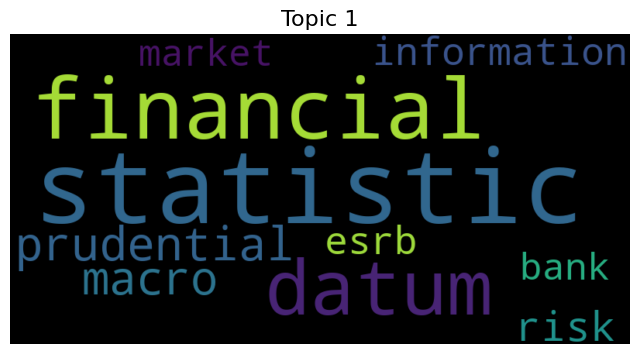

Topic 2:
['sepa', 'card', 'payment', 'scheme', 'retail', 'euro', 'european', 'area', 'bank', 'europe']



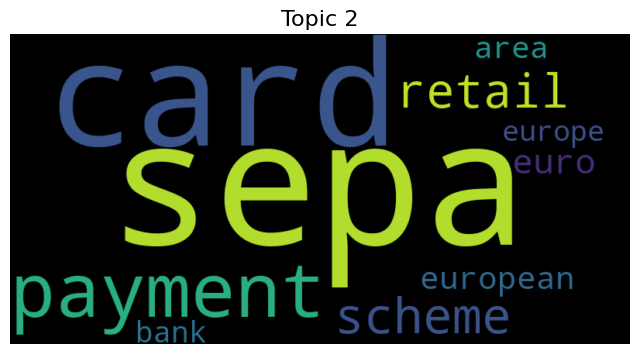

Topic 3:
['bank', 'euro', 'european', 'area', 'financial', 'policy', 'country', 'central', 'ecb', 'crisis']



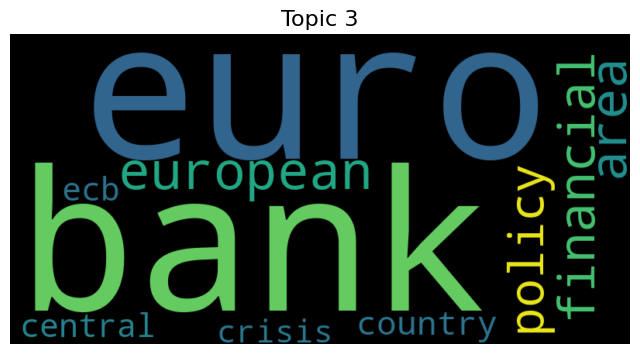

Topic 4:
['policy', 'inflation', 'monetary', 'cid', 'rate', 'price', 'bank', 'euro', 'economic', 'area']



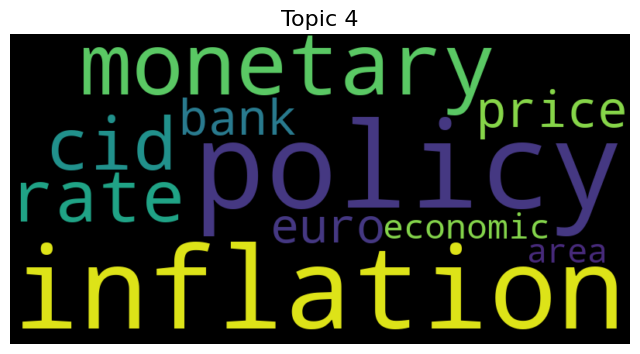

Topic 5:
['inflation', 'growth', 'euro', 'area', 'monetary', 'rate', 'continue', 'remain', 'policy', 'price']



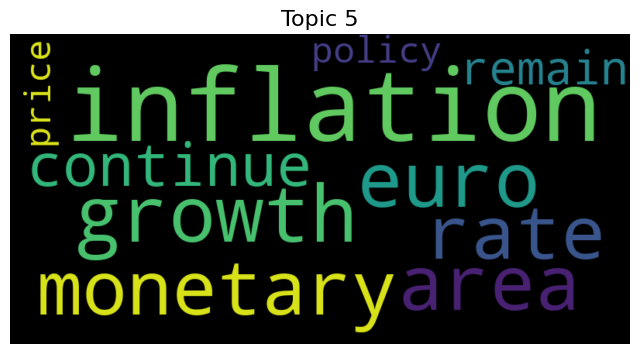

Topic 6:
['cid', 'climate', 'risk', 'green', 'bank', '10', 'transition', '11', 'relate', '13']



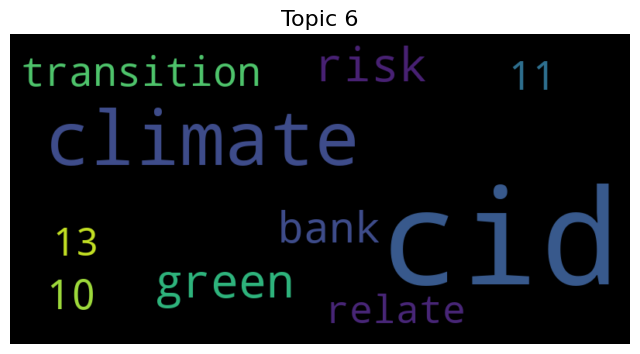

Topic 7:
['policy', 'euro', 'bank', 'area', 'monetary', 'ecb', 'central', 'market', 'rate', 'financial']



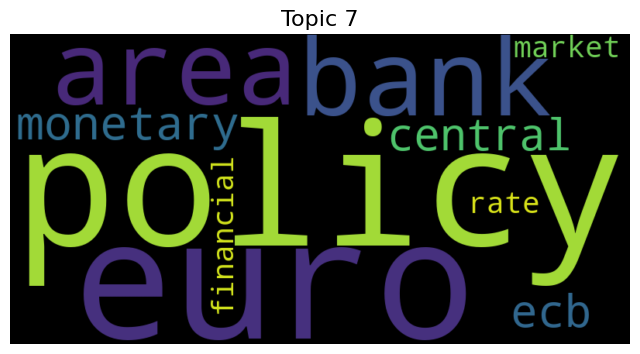

Topic 8:
['policy', 'bank', 'financial', 'monetary', 'market', 'rate', 'euro', 'inflation', 'area', 'central']



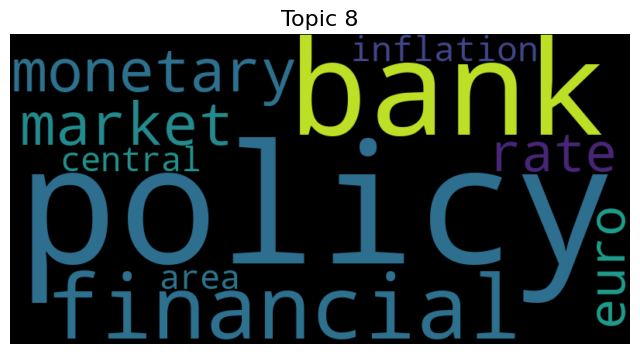

In [71]:
# display the top words + wordcloud for each topic
num_topics = lda_tfidf.num_topics

for topic_id in range(num_topics):
    # Get the top 10 words for each topic
    top_words = lda_tfidf.show_topic(topic_id, topn=10)
    print(f"Topic {topic_id + 1}:")
    print([word for word, prob in top_words])  # Extract just the words
    print()

    # wordcloud
    words = dict(lda_tfidf.show_topic(topic_id, topn=10))  # Get top 20 words for the topic
    wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(words)
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Topic {topic_id + 1}", fontsize=16)
    plt.axis("off")
    plt.show()

In [ ]:
from gensim.models import CoherenceModel

# Compute coherence score for the LDA model
coherence_model_lda = CoherenceModel(model=lda_tfidf, texts=speeches['cleaned_speech_tokens'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f"Coherence Score: {coherence_lda}") # 0.30


Coherence Score: 0.30337888086195397


In [75]:
import gensim
from gensim.corpora import Dictionary

# Prepare corpus for gensim LDA
texts = [text.split() for text in speeches['processed_content_topic_modeling']]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Train the LDA model with gensim
lda_gensim = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Compute Coherence Score
coherence_model_lda = gensim.models.CoherenceModel(model=lda_gensim, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()
print(f"Coherence Score: {coherence_score}")


Coherence Score: 0.4108517577942581


Topic 1:
['>', '<', '=', '$', '+', 'crypto', '=(', 'financial', 'policy', 'cid:0)(cid:2)(cid:3)(cid:3)(cid:4)(cid:5']



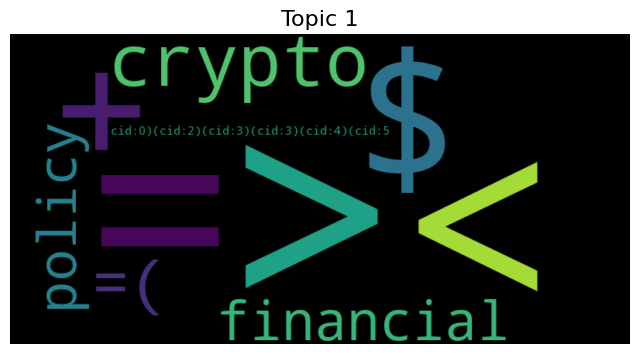

Topic 2:
['bank', 'market', 'payment', 'european', 'central', 'financial', 'euro', 'need', 'risk', 'digital']



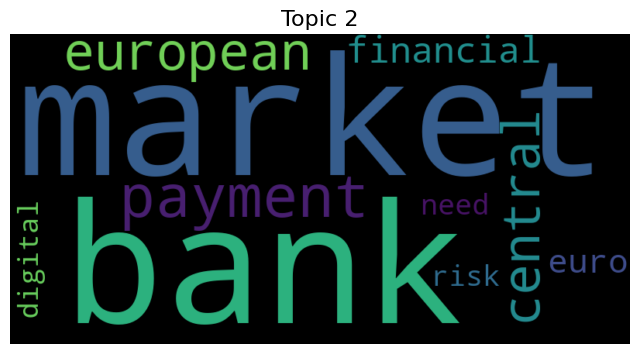

Topic 3:
['area', 'euro', 'growth', 'economic', 'monetary', 'inflation', 'policy', 'rate', 'remain', 'term']



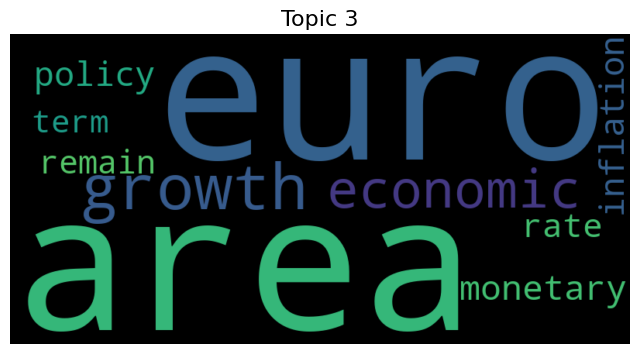

Topic 4:
['financial', 'bank', 'euro', 'risk', 'european', 'crisis', 'area', 'policy', 'market', 'central']



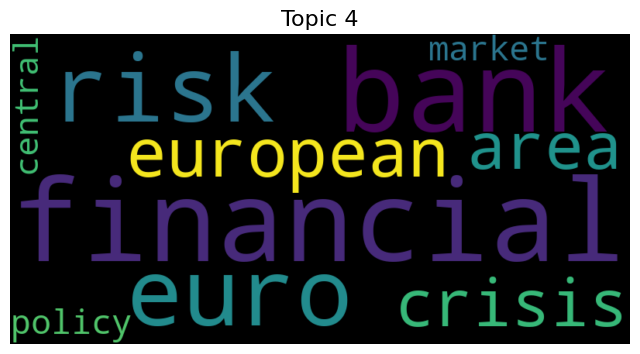

Topic 5:
['policy', 'rate', 'monetary', 'inflation', 'bank', 'central', 'ecb', 'market', 'price', 'euro']



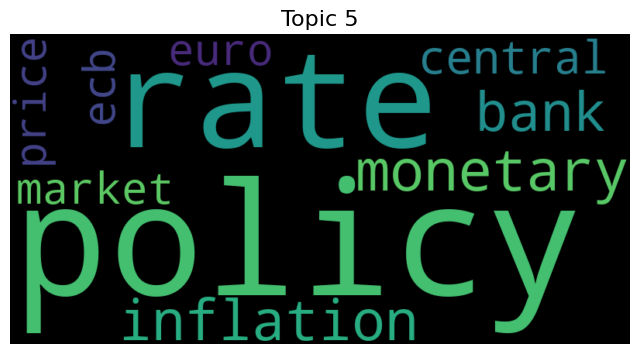

In [85]:
# display the top words + wordcloud for each topic
num_topics = lda_gensim.num_topics

for topic_id in range(num_topics):
    # Get the top 10 words for each topic
    top_words = lda_gensim.show_topic(topic_id, topn=10)
    print(f"Topic {topic_id + 1}:")
    print([word for word, prob in top_words])  # Extract just the words
    print()

    # wordcloud
    words = dict(lda_gensim.show_topic(topic_id, topn=10))  # Get top 20 words for the topic
    wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(words)
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Topic {topic_id + 1}", fontsize=16)
    plt.axis("off")
    plt.show()

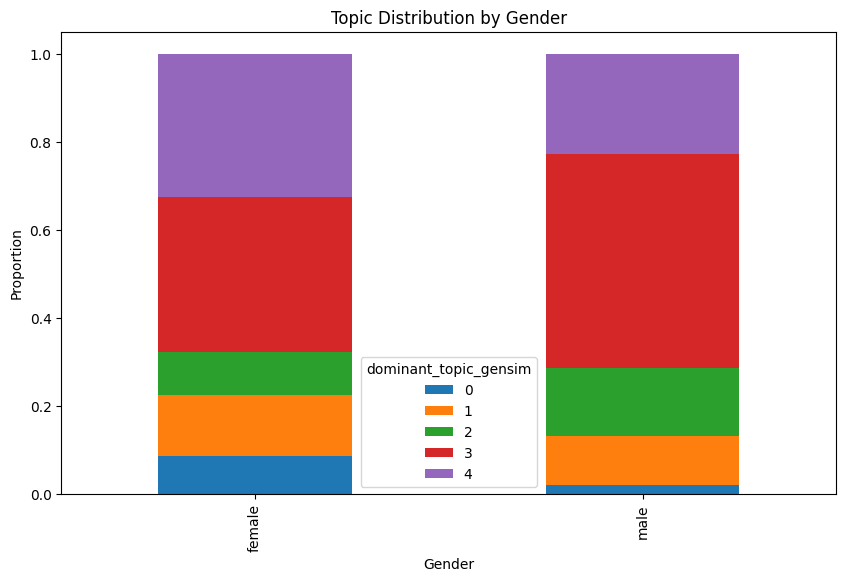

In [76]:
# Assign the dominant topic for each speech
speeches['dominant_topic_gensim'] = [max(lda_gensim[doc], key=lambda x: x[1])[0] for doc in corpus]

# Analyze topic distribution by gender
topic_by_gender = speeches.groupby(['gender', 'dominant_topic_gensim']).size().unstack().fillna(0)
topic_by_gender = topic_by_gender.div(topic_by_gender.sum(axis=1), axis=0)

# Plot topic distribution by gender
topic_by_gender.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Topic Distribution by Gender")
plt.xlabel("Gender")
plt.ylabel("Proportion")
plt.show()


With NMF :group tokens into topics that explain differences across documents

In [72]:
from sklearn.decomposition import NMF

# Initialize the NMF model
nmf = NMF(n_components=5, random_state=42, max_iter=500)

# Fit the model to the data
nmf.fit(X)

# Get the topics and display the top words for each topic
for topic_idx, topic in enumerate(nmf.components_):
    print(f"Topic {topic_idx + 1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))


Topic 1:
bank financial risk market banking central policy crisis supervisory supervision
Topic 2:
cid 10 11 13 14 12 15 16 17 18
Topic 3:
inflation policy rate monetary price area growth euro term economic
Topic 4:
euro area country european union crisis europe economic fiscal reform
Topic 5:
payment digital service retail sepa market infrastructure european card settlement


In [73]:
# n_components = 8
# m = NMF(
#     n_components=n_components,
#     init="nndsvd",
#     solver="cd",
#     beta_loss="frobenius",
#     random_state=1,
#     alpha_W=0,
#     l1_ratio=0,
#     max_iter=500,
# ).fit(X_tfidf)

H2_ = pd.DataFrame(nmf.components_.T, index=cols)
X_nmf = pd.DataFrame(nmf.transform(X_tfidf), index=speeches['processed_content_topic_modeling'].index)

H2_ = pd.DataFrame(nmf.components_.T, index=cols)
X_nmf = pd.DataFrame(nmf.transform(X_tfidf), index=speeches['processed_content_topic_modeling'].index)


def plot_word_embeddings(H, n=6): 
    fig, ax = plt.subplots(int(n/2), 2, figsize=(20, 16), sharex=True)
    plt.subplots_adjust(wspace=0.5)
    ax = ax.ravel()
    for i in range(n):
        bar(
            H[i].sort_values(ascending=False).head(10),
            horizontal=True,
            ax=ax[i],
            title=i,
        )
        
plot_word_embeddings(H2_)

ValueError: Shape of passed values is (1000, 5), indices imply (24442, 5)

In [74]:
topic_assignments = nmf.transform(X)
speeches['topic_nmf'] = topic_assignments.argmax(axis=1)


### EMPIRICAL RESULTS : BASELINE AND ROBUSTNESS

To effectively convey the empirical findings, separate the baseline results from the additional robustness tests. Within the primary empirical outcomes portion, include:

- Key statistical evaluations (for instance, if presenting a backtest – provide a pnl graph alongside the Sharpe ratio).

- Insights into what primarily influences the results, such as specific characteristics or assets that significantly impact performance.

The robustness of empirical tests section should detail:

- Evaluation of the stability of the principal finding against variations in hyperparameters or algorithmic modifications.

### CONCLUSION

Finally, the conclusive synthesis should recapitulate the primary findings, consider external elements that may influence the results, and hint at potential directions for further investigative work.

improvements : use LLMs to detect intention, sentiment ...

Actions:
Focus on Gender Differences in Sentiment Analysis:
Group the speeches by speaker gender (if metadata is available).
Calculate sentiment scores (using tools like VADER or TextBlob) and analyze distributions across genders.
Hypothesis Testing:
Formulate hypotheses, e.g., "Do male and female central bankers use different tones during economic crises?"
Validate them using statistical tests or machine learning models.


Task 3: Defining Research Objectives
Clarify Gender-Specific Sentiment Analysis:

Define how you will evaluate gender differences in sentiment. For example:
Compare sentiment scores between male and female speakers.
Examine if certain themes are more positively/negatively discussed by a specific gender.
Select Sentiment Analysis Tool:

Choose a sentiment analysis model or library (e.g., VADER, Hugging Face models).
Ensure it can handle the language used in central bank speeches.
Create a Hypothesis:

Draft testable hypotheses related to gender differences in sentiment.
E.g., "Speeches by female speakers will exhibit higher positive sentiment in discussing inclusive economic policies compared to male speakers."
Plan Statistical Tests:

Identify statistical tests (e.g., t-tests, ANOVA) to validate hypotheses.
Consider visualizations (e.g., boxplots, histograms) to support findings.